In [4]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_dir = 'data\\train'

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: DataLoader(
    image_datasets[x],
    batch_size=64,  # 增加批次大小，充分利用 GPU
    shuffle=(x=='train'),
    num_workers=12,  # 根據您的 CPU 核心數調整
    pin_memory=True,  # 加速 CPU->GPU 數據傳輸
    prefetch_factor=2,  # 每個 worker 預加載的批次數
    persistent_workers=True  # 避免每個 epoch 後重啟 workers
) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

['fcu_satellite_0',
 'fcu_satellite_1',
 'fcu_satellite_10',
 'fcu_satellite_11',
 'fcu_satellite_12',
 'fcu_satellite_13',
 'fcu_satellite_14',
 'fcu_satellite_15',
 'fcu_satellite_16',
 'fcu_satellite_17',
 'fcu_satellite_18',
 'fcu_satellite_19',
 'fcu_satellite_2',
 'fcu_satellite_20',
 'fcu_satellite_21',
 'fcu_satellite_22',
 'fcu_satellite_23',
 'fcu_satellite_24',
 'fcu_satellite_25',
 'fcu_satellite_26',
 'fcu_satellite_27',
 'fcu_satellite_28',
 'fcu_satellite_29',
 'fcu_satellite_3',
 'fcu_satellite_30',
 'fcu_satellite_31',
 'fcu_satellite_32',
 'fcu_satellite_33',
 'fcu_satellite_34',
 'fcu_satellite_35',
 'fcu_satellite_36',
 'fcu_satellite_37',
 'fcu_satellite_38',
 'fcu_satellite_39',
 'fcu_satellite_4',
 'fcu_satellite_40',
 'fcu_satellite_41',
 'fcu_satellite_42',
 'fcu_satellite_43',
 'fcu_satellite_44',
 'fcu_satellite_45',
 'fcu_satellite_46',
 'fcu_satellite_47',
 'fcu_satellite_48',
 'fcu_satellite_49',
 'fcu_satellite_5',
 'fcu_satellite_50',
 'fcu_satellite_51'

First, let's print the model architecture to understand its structure:

Run the above code to see the structure of the model. Look for the final layer that produces the class scores, typically named something like classifier, head, or fc.

In [6]:
# Step 4: Define the Model
# Load the FasterViT model and modify it for your number of classes.

from fastervit import create_model
from argparse import Namespace
from torch.serialization import add_safe_globals
add_safe_globals([Namespace])
# Load FasterViT model
model = create_model('faster_vit_0_224', 
                     pretrained=True,
                     model_path="tmp/faster_vit_0.pth.tar")

# Print the model architecture
print(model)

FasterViT(
  (patch_embed): PatchEmbed(
    (proj): Identity()
    (conv_down): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=0.0001, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
    )
  )
  (levels): ModuleList(
    (0): FasterViTLayer(
      (blocks): ModuleList(
        (0): ConvBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): GELU(approximate='none')
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s


From the model architecture, it looks like the final classification layer is named head. 

To modify this layer for your custom classification task, you should replace the head layer with a new Linear layer that has the appropriate number of output classes for your dataset.

In [7]:

# Modify the final layer for custom classification
num_ftrs = model.head.in_features
model.head = torch.nn.Linear(num_ftrs, len(class_names))

In [8]:
# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [9]:
import torch.optim as optim
from torch.optim import lr_scheduler

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Learning rate scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)


In [10]:
import time
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=5)

# Save the model
torch.save(model.state_dict(), 'faster_vit_custom_model.pth')

Epoch 0/4
----------
train Loss: 4.4959 Acc: 0.0350
val Loss: 4.2840 Acc: 0.0748

Epoch 1/4
----------
train Loss: 4.1165 Acc: 0.0932
val Loss: 3.7059 Acc: 0.2076

Epoch 2/4
----------
train Loss: 3.5922 Acc: 0.1995
val Loss: 3.0882 Acc: 0.3851

Epoch 3/4
----------
train Loss: 3.0538 Acc: 0.3415
val Loss: 2.4735 Acc: 0.6114

Epoch 4/4
----------
train Loss: 2.5230 Acc: 0.5163
val Loss: 1.8522 Acc: 0.8003

Training complete in 8m 34s
Best val Acc: 0.8003


# Testing

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import os
import time
from tqdm import tqdm  # 添加進度條顯示

# 使用和訓練相同的設備
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 確保模型在評估模式
model.eval()

# 定義測試數據轉換 
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 載入測試數據集
test_dataset = datasets.ImageFolder('data\\train', test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# 使用動態類別數量
num_classes = len(test_dataset.classes)
class_correct = [0] * num_classes
class_total = [0] * num_classes
class_predictions = [0] * num_classes
total_correct = 0
total_samples = 0


# 計算開始時間
start_time = time.time()

# 使用進度條跟踪測試進度
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="測試進度"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 模型預測
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        
        # 統計整體正確數
        correct = (predictions == labels).sum().item()
        total_correct += correct
        total_samples += labels.size(0)
        
        # 統計每個類別的正確數和總數
        for i in range(len(labels)):
            label = labels[i].item()
            prediction = predictions[i].item()
            class_total[label] += 1
            if label == prediction:
                class_correct[label] += 1
            
            # 統計每個類別被預測的次數
            class_predictions[prediction] += 1

# 計算測試時間
test_time = time.time() - start_time

# 輸出總體準確率
overall_accuracy = 100 * total_correct / total_samples
print(f'總體準確率: {overall_accuracy:.2f}% ({total_correct}/{total_samples})')
print(f'測試完成，耗時: {test_time:.2f} 秒')

# 輸出每個類別的準確率
print("\n各類別準確率:")
for i in range(100):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f'類別 {i}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})')

# 輸出每個類別被預測到的次數
print("\n各類別被預測次數:")
for i in range(100):
    print(f'類別 {i}: {class_predictions[i]}')

測試進度: 100%|██████████| 157/157 [00:40<00:00,  3.88it/s]

總體準確率: 80.23% (8023/10000)
測試完成，耗時: 40.54 秒

各類別準確率:
類別 0: 72.00% (72/100)
類別 1: 85.00% (85/100)
類別 2: 77.00% (77/100)
類別 3: 80.00% (80/100)
類別 4: 19.00% (19/100)
類別 5: 86.00% (86/100)
類別 6: 77.00% (77/100)
類別 7: 73.00% (73/100)
類別 8: 80.00% (80/100)
類別 9: 80.00% (80/100)
類別 10: 77.00% (77/100)
類別 11: 91.00% (91/100)
類別 12: 49.00% (49/100)
類別 13: 53.00% (53/100)
類別 14: 84.00% (84/100)
類別 15: 17.00% (17/100)
類別 16: 42.00% (42/100)
類別 17: 95.00% (95/100)
類別 18: 68.00% (68/100)
類別 19: 58.00% (58/100)
類別 20: 82.00% (82/100)
類別 21: 95.00% (95/100)
類別 22: 32.00% (32/100)
類別 23: 86.00% (86/100)
類別 24: 79.00% (79/100)
類別 25: 76.00% (76/100)
類別 26: 86.00% (86/100)
類別 27: 100.00% (100/100)
類別 28: 60.00% (60/100)
類別 29: 98.00% (98/100)
類別 30: 81.00% (81/100)
類別 31: 76.00% (76/100)
類別 32: 20.00% (20/100)
類別 33: 100.00% (100/100)
類別 34: 30.00% (30/100)
類別 35: 94.00% (94/100)
類別 36: 61.00% (61/100)
類別 37: 87.00% (87/100)
類別 38: 92.00% (92/100)
類別 39: 87.00% (87/100)
類別 40: 95.00% (95/100)
類別 41: 75.

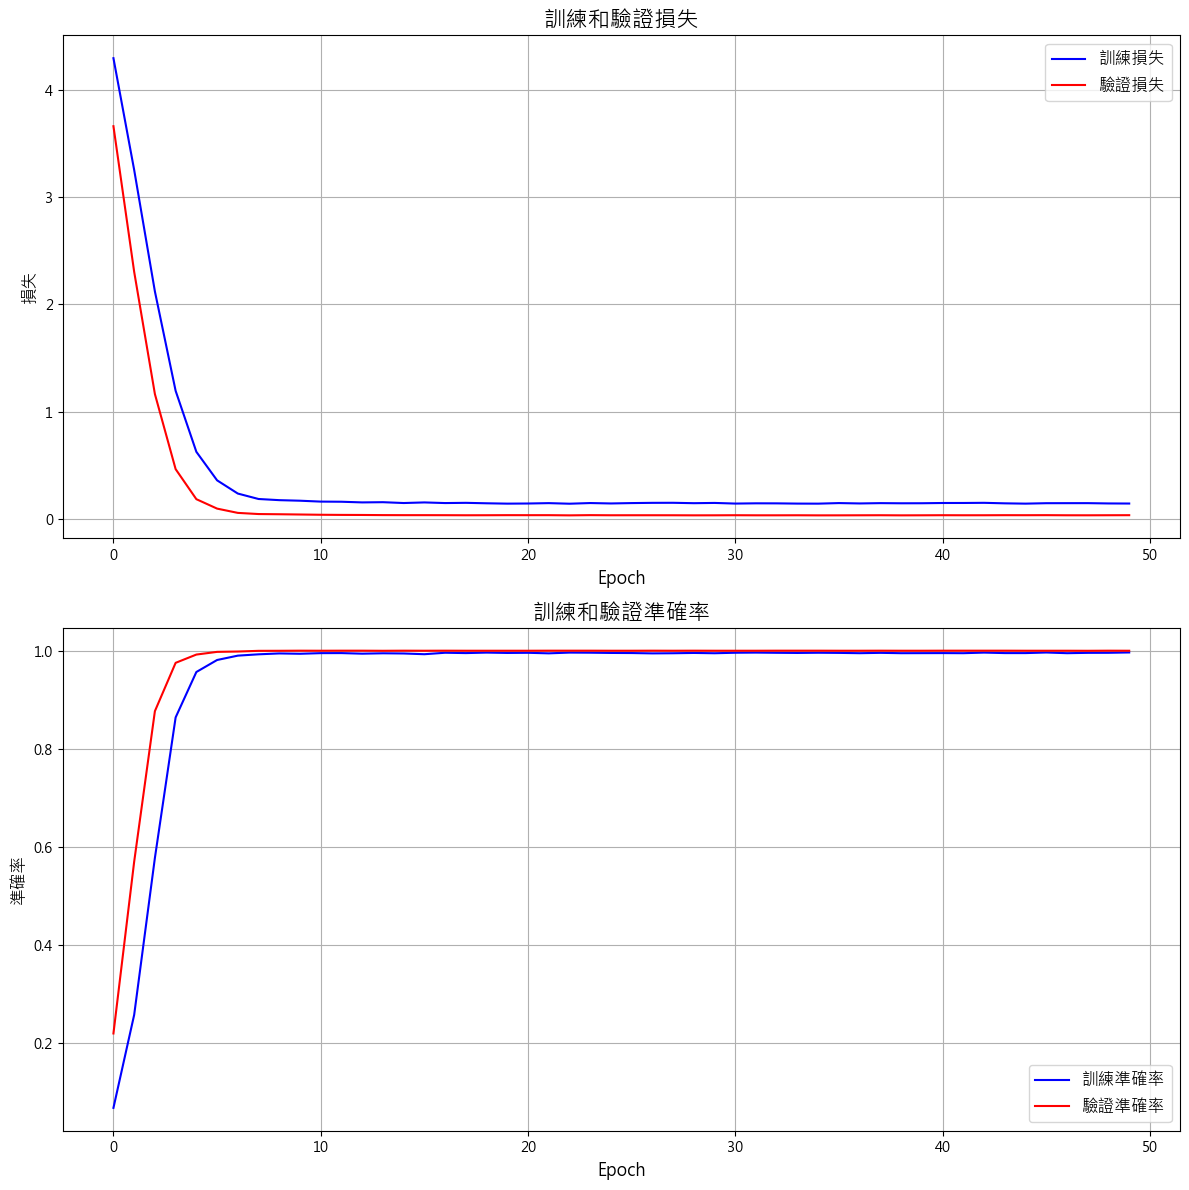

最終訓練損失: 0.1418, 最終訓練準確率: 0.9964
最終驗證損失: 0.0330, 最終驗證準確率: 0.9999
最佳驗證準確率: 1.0000 (多個epoch達到)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 從訓練記錄中提取數據
epochs = list(range(50))
train_loss = [4.2973, 3.2549, 2.1206, 1.1934, 0.6243, 0.3582, 0.2349, 0.1841, 0.1733, 0.1681, 
              0.1598, 0.1585, 0.1523, 0.1543, 0.1465, 0.1521, 0.1462, 0.1483, 0.1441, 0.1408, 
              0.1420, 0.1455, 0.1401, 0.1463, 0.1425, 0.1460, 0.1482, 0.1487, 0.1450, 0.1474, 
              0.1414, 0.1438, 0.1434, 0.1412, 0.1407, 0.1460, 0.1426, 0.1455, 0.1441, 0.1445, 
              0.1468, 0.1470, 0.1484, 0.1436, 0.1408, 0.1449, 0.1452, 0.1454, 0.1426, 0.1418]

train_acc = [0.0666, 0.2565, 0.5770, 0.8638, 0.9565, 0.9810, 0.9899, 0.9926, 0.9944, 0.9937, 
             0.9950, 0.9951, 0.9939, 0.9947, 0.9943, 0.9928, 0.9958, 0.9951, 0.9961, 0.9954, 
             0.9957, 0.9946, 0.9961, 0.9959, 0.9954, 0.9952, 0.9945, 0.9948, 0.9954, 0.9948, 
             0.9958, 0.9961, 0.9957, 0.9954, 0.9958, 0.9955, 0.9949, 0.9956, 0.9949, 0.9950, 
             0.9951, 0.9949, 0.9961, 0.9951, 0.9951, 0.9963, 0.9949, 0.9956, 0.9957, 0.9964]

val_loss = [3.6626, 2.3042, 1.1632, 0.4627, 0.1824, 0.0944, 0.0545, 0.0437, 0.0418, 0.0394, 
            0.0370, 0.0357, 0.0351, 0.0338, 0.0333, 0.0333, 0.0330, 0.0323, 0.0326, 0.0333, 
            0.0331, 0.0332, 0.0314, 0.0335, 0.0323, 0.0325, 0.0325, 0.0323, 0.0316, 0.0319, 
            0.0327, 0.0319, 0.0319, 0.0323, 0.0314, 0.0316, 0.0321, 0.0326, 0.0315, 0.0320, 
            0.0328, 0.0323, 0.0324, 0.0331, 0.0328, 0.0333, 0.0322, 0.0320, 0.0326, 0.0330]

val_acc = [0.2185, 0.5692, 0.8766, 0.9752, 0.9921, 0.9976, 0.9983, 0.9997, 0.9998, 1.0000, 
           0.9999, 1.0000, 1.0000, 0.9998, 1.0000, 0.9999, 1.0000, 0.9999, 0.9999, 0.9999, 
           0.9999, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 0.9999, 1.0000, 0.9999, 
           0.9999, 0.9999, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 1.0000, 0.9999, 0.9999, 
           1.0000, 1.0000, 1.0000, 1.0000, 0.9999, 0.9999, 0.9999, 0.9998, 1.0000, 0.9999]

# 設置中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
plt.rcParams['axes.unicode_minus'] = False

# 創建包含兩個子圖的圖表
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# 繪製損失曲線
ax1.plot(epochs, train_loss, 'b-', label='訓練損失')
ax1.plot(epochs, val_loss, 'r-', label='驗證損失')
ax1.set_title('訓練和驗證損失', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('損失', fontsize=12)
ax1.legend(fontsize=12)
ax1.grid(True)

# 繪製準確率曲線
ax2.plot(epochs, train_acc, 'b-', label='訓練準確率')
ax2.plot(epochs, val_acc, 'r-', label='驗證準確率')
ax2.set_title('訓練和驗證準確率', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('準確率', fontsize=12)
ax2.legend(fontsize=12)
ax2.grid(True)

# 顯示圖表
plt.tight_layout()
plt.show()

# 擷取關鍵統計資訊
print(f"最終訓練損失: {train_loss[-1]:.4f}, 最終訓練準確率: {train_acc[-1]:.4f}")
print(f"最終驗證損失: {val_loss[-1]:.4f}, 最終驗證準確率: {val_acc[-1]:.4f}")
print(f"最佳驗證準確率: 1.0000 (多個epoch達到)")